<a href="https://colab.research.google.com/github/danielpatrickhug/kernel-trick/blob/main/grad_check.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*note: you should use a larger dataset before making any assumptions

In [ ]:
import numpy as np
# Usage
m = 5
n = 3
embedding_matrix = np.random.lognormal(size=(m, n))

def check_symmetry(kernel_matrix):
    # Check if the input matrix is square
    if kernel_matrix.shape[0] != kernel_matrix.shape[1]:
        raise ValueError("The input kernel matrix must be square.")

    # Check if the difference between the matrix and its transpose is close to zero
    is_symmetric = np.allclose(kernel_matrix, kernel_matrix.T, atol=1e-8)

    return is_symmetric

def is_positive_semi_definite(kernel_matrix):
    # Check if the input matrix is square
    if kernel_matrix.shape[0] != kernel_matrix.shape[1]:
        raise ValueError("The input kernel matrix must be square.")
    
    # Compute the eigenvalues of the kernel matrix
    eigenvalues = np.linalg.eigvalsh(kernel_matrix)
    
    # Check if all eigenvalues are non-negative (within a small tolerance)
    is_psd = np.all(eigenvalues >= -1e-8)
    
    return is_psd
    
def is_negative_semi_definite(kernel_matrix):
    # Check if the input matrix is square
    if kernel_matrix.shape[0] != kernel_matrix.shape[1]:
        raise ValueError("The input kernel matrix must be square.")
    
    # Compute the eigenvalues of the kernel matrix
    eigenvalues = np.linalg.eigvalsh(kernel_matrix)
    
    # Check if all eigenvalues are non-positive (within a small tolerance)
    is_nsd = np.all(eigenvalues <= 1e-8)
    
    return is_nsd

def has_mixed_eigenvalues(kernel_matrix):
    # Check if the input matrix is square
    if kernel_matrix.shape[0] != kernel_matrix.shape[1]:
        raise ValueError("The input kernel matrix must be square.")
    
    # Compute the eigenvalues of the kernel matrix
    eigenvalues = np.linalg.eigvalsh(kernel_matrix)
    
    # Check if there are both negative and non-negative eigenvalues
    has_negative = np.any(eigenvalues < -1e-8)
    has_non_negative = np.any(eigenvalues > 1e-8)
    is_mixed = has_negative and has_non_negative
    
    return is_mixed


def gram_matrix(embedding_matrix):
    # Compute the kernel matrix using matrix multiplication. AAT
    kernel_matrix = np.matmul(embedding_matrix, embedding_matrix.T)
    return kernel_matrix


def covariance_matrix(embedding_matrix):
    # Compute the kernel matrix using matrix multiplication. AAT
    m, n = embedding_matrix.shape  # number of samples (m) and number of features (n)
    mean_centered_matrix = embedding_matrix - np.mean(embedding_matrix, axis=0)  # centering the data
    cov_matrix = np.matmul(mean_centered_matrix.T, mean_centered_matrix) / (m - 1)  # calculating covariance matrix

    return cov_matrix

def eigen_topic(A, r1 = 0, r2=2):
    # A.shape = (embedding dim, num of articles)
    avg_doc = np.mean(A, axis=1)
    # avg_doc.shape = (embedding dim, 1)
    # Compute eigenfaces on mean-subtracted training data
    X = A - np.tile(avg_doc,(A.shape[1],1)).T
    # X.shape = A.shape
    # SVD on Mean-centered articles
    U, S, VT = svd(X)
    # U.shape = (embedding dim, embedding dim)
    # np.diag(S.shape) = (embedding dim, embedding dim)
    # VT.shape = (num of articles, num of articles)
    econ_UT = U[:, r1:r2].T
    # econ_UT.shape = (r2-r1, emmbedding dim)
    transformed_matrix = econ_UT @ X
    # transformed_matrix.shape = (r2-r1, num of articles)
    return transformed_matrix, avg_doc, econ_UT

In [ ]:
from collections import defaultdict

class CounterDict:
    def __init__(self, keys):
        self.counts = defaultdict(int)
        for key in keys:
            self.counts[key] = 0

    def increment(self, key):
        if key in self.counts:
            self.counts[key] += 1
        else:
            raise KeyError(f"{key} not found in CounterDict keys.")

    def get_count(self, key):
        if key in self.counts:
            return self.counts[key]
        else:
            raise KeyError(f"{key} not found in CounterDict keys.")
    
    def format_print(self):
        for key, value in self.counts.items():
            print(f'{key}: {value}')
            
    def plot_counts(self):
        keys = list(self.counts.keys())
        values = list(self.counts.values())
        
        plt.bar(keys, values)
        plt.xlabel('Keys')
        plt.ylabel('Counts')
        plt.title('Counts of each key')
        plt.show()



In [ ]:
import numpy as np
from numpy.linalg import svd


keys = ['psd', 'nsd', 'mixed']
counter = CounterDict(keys)
# Perform transformation for all r2 values from 2 to m and check properties of the resulting Gram matrix
for r2 in range(2, m+1):
    transformed_matrix, avg_doc, econ_UT = eigen_topic(embedding_matrix, r1=0, r2=r2)

    A_transformed = gram_matrix(transformed_matrix.T)
    is_psd = is_positive_semi_definite(A_transformed)
    is_nsd = is_negative_semi_definite(A_transformed)
    is_mixed = has_mixed_eigenvalues(A_transformed)
    is_sym =  check_symmetry(A_transformed)
    assert sum([is_psd, is_nsd, is_mixed]) == 1
    if is_psd:
        counter.increment("psd")
        print(f'Shape of transformed {transformed_matrix.T.shape}')
        print(f"For r2={r2}:")
        print("\tSymmetry of Gram matrix: ",is_sym)
        print("\tPositive semi-definite property of A matrix: ", is_psd)
        print()
    elif is_nsd:
        counter.increment("nsd")
        print(f'Shape of transformed {transformed_matrix.T.shape}')
        print(f"For r2={r2}:")
        print("\tSymmetry of A matrix: ",is_sym)
        print("\tNegative semi-definite property of A matrix: ", is_nsd)
        print()
    elif is_mixed:
        counter.increment("mixed")
        print(f'Shape of transformed {transformed_matrix.T.shape}')
        print(f"For r2={r2}:")
        print("\tSymmetry of A matrix: ",is_sym)
        print("\tMixed  eigenvalue property of A matrix: ", is_mixed)
        print()


Shape of transformed (3, 2)
For r2=2:
	Symmetry of Gram matrix:  True
	Positive semi-definite property of A matrix:  True

Shape of transformed (3, 3)
For r2=3:
	Symmetry of Gram matrix:  True
	Positive semi-definite property of A matrix:  True

Shape of transformed (3, 4)
For r2=4:
	Symmetry of Gram matrix:  True
	Positive semi-definite property of A matrix:  True

Shape of transformed (3, 5)
For r2=5:
	Symmetry of Gram matrix:  True
	Positive semi-definite property of A matrix:  True



psd: 4
nsd: 0
mixed: 0


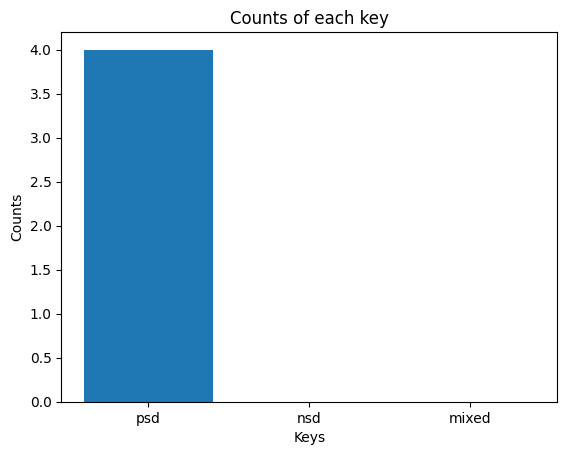

In [ ]:
# Pretty print counts
counter.format_print()

# Plot counts
counter.plot_counts()

In [ ]:
%%capture
!pip install sentence-transformers
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cdist
from scipy.linalg import svdvals
from sentence_transformers import SentenceTransformer


# Create SBERT model and load pre-trained weights
model = SentenceTransformer('all-MiniLM-L6-v2')


In [ ]:

# Example sentences
sentences = [
    'I enjoy taking long walks on the beach.',
    'The sun is shining brightly today.',
    'I love eating ice cream.',
    'Reading books is my favorite pastime.',
    'Traveling to new places is always exciting.',
    'I like to play basketball with my friends.',
    'Pizza is my go-to comfort food.',
    'Learning new things is a never-ending journey.',
    'Nature always brings me a sense of peace.',
    'Music has the power to uplift my mood.',
    'I find joy in spending time with my family.',
    'Exploring different cultures is enriching.',
    'Cooking is a creative and therapeutic activity for me.',
    'The beauty of a sunset is captivating.',
    'Laughter is the best medicine.',
    'I appreciate the little things in life.',
    'Exercise helps me stay physically and mentally fit.',
    'Writing allows me to express my thoughts and emotions.',
    'Friendship is a treasure to be cherished.',
    'A good cup of coffee starts my day off right.'
]


# Embed sentences using SBERT
embeddings = model.encode(sentences)

In [ ]:
def cosine_kernel_function(embedding_matrix):
    # Normalize each row (vector) in the matrix
    normed_matrix = embedding_matrix / np.linalg.norm(embedding_matrix, axis=1, keepdims=True)
    
    # Compute the kernel matrix using matrix multiplication
    kernel_matrix = np.matmul(normed_matrix, normed_matrix.T)
    
    return kernel_matrix

In [ ]:
A = cosine_kernel_function(embeddings)
print("\tSymmetry of A matrix: ", check_symmetry(A))
print("\tPositive semi-definite property of Gram matrix: ", is_positive_semi_definite(A))

	Symmetry of Gram matrix:  True
	Positive semi-definite property of Gram matrix:  True


In [ ]:
m = embeddings.shape[1]

In [ ]:
keys = ['psd', 'nsd', 'mixed']
counter = CounterDict(keys)
# Perform transformation for all r2 values from 2 to m and check properties of the resulting Gram matrix
for r2 in range(1, m):
    transformed_matrix, avg_doc, econ_UT = eigen_topic(embeddings.T, r1=0, r2=r2)
    
    A_transformed = cosine_kernel_function(transformed_matrix.T)

    
    is_psd = is_positive_semi_definite(A_transformed)
    is_nsd = is_negative_semi_definite(A_transformed)
    is_mixed = has_mixed_eigenvalues(A_transformed)
    is_sym =  check_symmetry(A_transformed)
    assert sum([is_psd, is_nsd, is_mixed]) == 1
    if is_psd:
        counter.increment("psd")
        print(f'Shape of transformed {transformed_matrix.T.shape}')
        print(f"For r2={r2}:")
        print("\tSymmetry of A matrix: ",is_sym)
        print("\tPositive semi-definite property of A matrix: ", is_psd)
        print()
    elif is_nsd:
        counter.increment("nsd")
        print(f'Shape of transformed {transformed_matrix.T.shape}')
        print(f"For r2={r2}:")
        print("\tSymmetry of A matrix: ",is_sym)
        print("\tNegative semi-definite property of A matrix: ", is_nsd)
        print()
    elif is_mixed:
        counter.increment("mixed")
        print(f'Shape of transformed {transformed_matrix.T.shape}')
        print(f"For r2={r2}:")
        print("\tSymmetry of A matrix: ",is_sym)
        print("\tMixed  eigenvalue property of A matrix: ", is_mixed)
        print()



Shape of transformed (20, 1)
For r2=1:
	Symmetry of Gram matrix:  True
	Positive semi-definite property of A matrix:  True

Shape of transformed (20, 2)
For r2=2:
	Symmetry of A matrix:  True
	Mixed  eigenvalue property of A matrix:  True

Shape of transformed (20, 3)
For r2=3:
	Symmetry of A matrix:  True
	Mixed  eigenvalue property of A matrix:  True

Shape of transformed (20, 4)
For r2=4:
	Symmetry of A matrix:  True
	Mixed  eigenvalue property of A matrix:  True

Shape of transformed (20, 5)
For r2=5:
	Symmetry of A matrix:  True
	Mixed  eigenvalue property of A matrix:  True

Shape of transformed (20, 6)
For r2=6:
	Symmetry of A matrix:  True
	Mixed  eigenvalue property of A matrix:  True

Shape of transformed (20, 7)
For r2=7:
	Symmetry of A matrix:  True
	Mixed  eigenvalue property of A matrix:  True

Shape of transformed (20, 8)
For r2=8:
	Symmetry of A matrix:  True
	Mixed  eigenvalue property of A matrix:  True

Shape of transformed (20, 9)
For r2=9:
	Symmetry of A matrix:  T

psd: 367
nsd: 0
mixed: 16


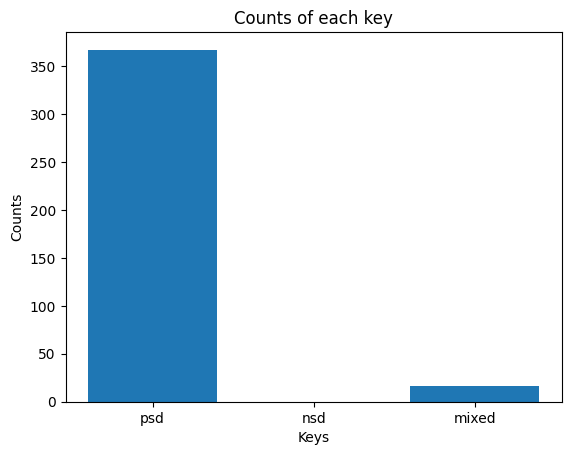

In [ ]:
# Pretty print counts
counter.format_print()

# Plot counts
counter.plot_counts()

In [ ]:

# Example sentences
sentences = [
    'I enjoy taking long walks on the beach.',
    'The sun is shining brightly today.',
    'I love eating ice cream.',
    'Reading books is my favorite pastime.',
    'Traveling to new places is always exciting.',
    'I like to play basketball with my friends.',
    'Pizza is my go-to comfort food.',
]


# Embed sentences using SBERT
embeddings = model.encode(sentences)

In [ ]:
# Perform transformation for all r2 values from 2 to m and check properties of the resulting Gram matrix
keys = ['psd', 'nsd', 'mixed']
counter = CounterDict(keys)
for r2 in range(2,m):
    transformed_matrix, avg_doc, econ_UT = eigen_topic(embeddings.T, r1=0, r2=r2)
    A_transformed = cosine_kernel_function(transformed_matrix.T)

    
    is_psd = is_positive_semi_definite(A_transformed)
    is_nsd = is_negative_semi_definite(A_transformed)
    is_mixed = has_mixed_eigenvalues(A_transformed)
    is_sym =  check_symmetry(A_transformed)
    assert sum([is_psd, is_nsd, is_mixed]) == 1
    if is_psd:
        counter.increment("psd")
        print(f'Shape of transformed {transformed_matrix.T.shape}')
        print(f"For r2={r2}:")
        print("\tSymmetry of A matrix: ",is_sym)
        print("\tPositive semi-definite property of A matrix: ", is_psd)
        print()
    elif is_nsd:
        counter.increment("nsd")
        print(f'Shape of transformed {transformed_matrix.T.shape}')
        print(f"For r2={r2}:")
        print("\tSymmetry of A matrix: ",is_sym)
        print("\tNegative semi-definite property of A matrix: ", is_nsd)
        print()
    elif is_mixed:
        counter.increment("mixed")
        print(f'Shape of transformed {transformed_matrix.T.shape}')
        print(f"For r2={r2}:")
        print("\tSymmetry of A matrix: ",is_sym)
        print("\tMixed  eigenvalue property of A matrix: ", is_mixed)
        print()


Shape of transformed (7, 2)
For r2=2:
	Symmetry of A matrix:  True
	Mixed  eigenvalue property of A matrix:  True

Shape of transformed (7, 3)
For r2=3:
	Symmetry of A matrix:  True
	Mixed  eigenvalue property of A matrix:  True

Shape of transformed (7, 4)
For r2=4:
	Symmetry of A matrix:  True
	Mixed  eigenvalue property of A matrix:  True

Shape of transformed (7, 5)
For r2=5:
	Symmetry of Gram matrix:  True
	Positive semi-definite property of A matrix:  True

Shape of transformed (7, 6)
For r2=6:
	Symmetry of A matrix:  True
	Mixed  eigenvalue property of A matrix:  True

Shape of transformed (7, 7)
For r2=7:
	Symmetry of A matrix:  True
	Mixed  eigenvalue property of A matrix:  True

Shape of transformed (7, 8)
For r2=8:
	Symmetry of A matrix:  True
	Mixed  eigenvalue property of A matrix:  True

Shape of transformed (7, 9)
For r2=9:
	Symmetry of A matrix:  True
	Mixed  eigenvalue property of A matrix:  True

Shape of transformed (7, 10)
For r2=10:
	Symmetry of A matrix:  True
	Mi

psd: 1
nsd: 0
mixed: 381


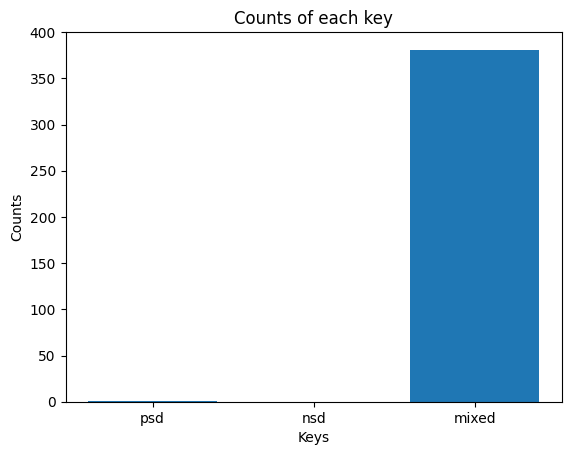

In [ ]:
# Pretty print counts
counter.format_print()

# Plot counts
counter.plot_counts()

In [ ]:
def svd_outer(B, c):
    U, s, VT = svd(B)
    print(U.shape, s.shape, VT.shape)
    M_cs = [s[i]*np.outer(U[:,i], VT[i,:]) for i in range(c)]
    
    return sum(M_cs)

In [ ]:
# Perform transformation for all r2 values from 2 to m and check properties of the resulting Gram matrix
keys = ['psd', 'nsd', 'mixed']
counter = CounterDict(keys)
for r2 in range(2,7):
    transformed_matrix = svd_outer(embeddings.T,c=r2)
    print(transformed_matrix.shape)
    A_transformed = cosine_kernel_function(transformed_matrix.T)
    print(A_transformed.shape)
    
    is_psd = is_positive_semi_definite(A_transformed)
    is_nsd = is_negative_semi_definite(A_transformed)
    is_mixed = has_mixed_eigenvalues(A_transformed)
    is_sym =  check_symmetry(A_transformed)
    assert sum([is_psd, is_nsd, is_mixed]) == 1
    if is_psd:
        counter.increment("psd")
        print(f'Shape of transformed {transformed_matrix.T.shape}')
        print(f"For r2={r2}:")
        print("\tSymmetry of A matrix: ",is_sym)
        print("\tPositive semi-definite property of A matrix: ", is_psd)
        print()
    elif is_nsd:
        counter.increment("nsd")
        print(f'Shape of transformed {transformed_matrix.T.shape}')
        print(f"For r2={r2}:")
        print("\tSymmetry of A matrix: ",is_sym)
        print("\tNegative semi-definite property of A matrix: ", is_nsd)
        print()
    elif is_mixed:
        counter.increment("mixed")
        print(f'Shape of transformed {transformed_matrix.T.shape}')
        print(f"For r2={r2}:")
        print("\tSymmetry of A matrix: ",is_sym)
        print("\tMixed  eigenvalue property of A matrix: ", is_mixed)
        print()


(384, 384) (7,) (7, 7)
(384, 7)
(7, 7)
Shape of transformed (7, 384)
For r2=2:
	Symmetry of A matrix:  True
	Mixed  eigenvalue property of A matrix:  True

(384, 384) (7,) (7, 7)
(384, 7)
(7, 7)
Shape of transformed (7, 384)
For r2=3:
	Symmetry of A matrix:  True
	Mixed  eigenvalue property of A matrix:  True

(384, 384) (7,) (7, 7)
(384, 7)
(7, 7)
Shape of transformed (7, 384)
For r2=4:
	Symmetry of A matrix:  True
	Mixed  eigenvalue property of A matrix:  True

(384, 384) (7,) (7, 7)
(384, 7)
(7, 7)
Shape of transformed (7, 384)
For r2=5:
	Symmetry of Gram matrix:  True
	Positive semi-definite property of A matrix:  True

(384, 384) (7,) (7, 7)
(384, 7)
(7, 7)
Shape of transformed (7, 384)
For r2=6:
	Symmetry of A matrix:  True
	Mixed  eigenvalue property of A matrix:  True



psd: 1
nsd: 0
mixed: 4


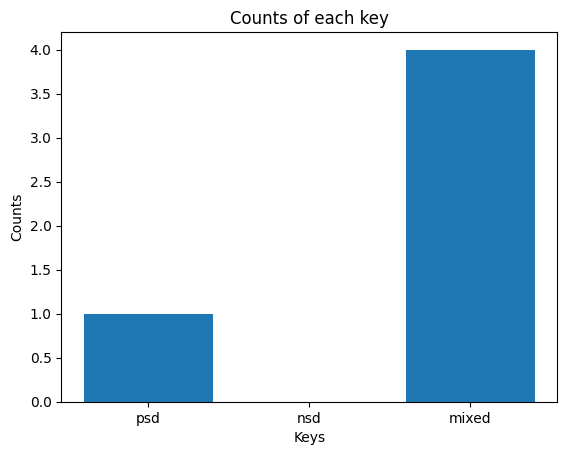

In [ ]:
# Pretty print counts
counter.format_print()

# Plot counts
counter.plot_counts()

In [ ]:
from scipy.linalg import solve_sylvester
from typing import Tuple
def graph_sylvester_embedding(G: Tuple, m: int, ts: np.ndarray) -> np.ndarray:
    """
    Compute the spectral kernel descriptor or the Spectral Graph Wavelet descriptor.

    Args:
        G (Tuple): A tuple containing the graph's vertices (V) and weights (W).
        m (int): The number of singular values to consider.
        ts (np.ndarray): The spectral scales.

    Returns:
        np.ndarray: The node_embeddings matrix.
    """
    V, W = G
    n = len(V)
    D_BE = np.diag(W.sum(axis=1))
    L_BE = np.identity(n) - np.dot(
        np.diag(1 / np.sqrt(D_BE.diagonal())),
        np.dot(W, np.diag(1 / np.sqrt(D_BE.diagonal()))),
    )

    A = W
    B = L_BE
    C = np.identity(n)
    X = solve_sylvester(A, B, C)

    U, S, _ = svd(X, full_matrices=False)
    #print(S)
    U_m = U[:, :m]
    S_m = S[:m]

    node_embeddings = np.zeros((n, m))

    for i in range(n):
        for s in range(m):
            # Spectral kernel descriptor
            node_embeddings[i, s] = np.exp(-ts[s] * S_m[s]) * U_m[i, s]

    return node_embeddings

def gen_gse_embeddings(
    A: np.ndarray, embeddings: np.ndarray, m: int = 2
) -> np.ndarray:
    """
    Generate Graph Sylvester Embeddings.

    Args:
        A (np.ndarray): The adjacency matrix of the graph.
        embeddings (np.ndarray): The original node embeddings.
        m (int, optional): The number of spectral scales. Defaults to 7.

    Returns:
        np.ndarray: The generated Graph Sylvester Embeddings.
    """
    V = list(range(len(embeddings)))
    W = A

    G = (V, W)
    ts = np.linspace(0, 1, m)  # equally spaced scales
    m = min(m, min(embeddings.shape))
    gse_embeddings = graph_sylvester_embedding(G, m, ts)
    return gse_embeddings

In [ ]:
# Perform transformation for all r2 values from 2 to m and check properties of the resulting Gram matrix
keys = ['psd', 'nsd', 'mixed']
counter = CounterDict(keys)
for r2 in range(2,9):
    A = cosine_kernel_function(embeddings)
    transformed_matrix = gen_gse_embeddings(A, embeddings, r2)
    
    print(f'transformed_matrix.shape {transformed_matrix.shape}')
    A_transformed = cosine_kernel_function(transformed_matrix)
    print(f'A_transformed.shape {A_transformed.shape}')
    
    is_psd = is_positive_semi_definite(A_transformed)
    is_nsd = is_negative_semi_definite(A_transformed)
    is_mixed = has_mixed_eigenvalues(A_transformed)
    is_sym =  check_symmetry(A_transformed)
    assert sum([is_psd, is_nsd, is_mixed]) == 1
    if is_psd:
        counter.increment("psd")
        print(f"For r2={r2}:")
        print("\tSymmetry of A matrix: ",is_sym)
        print("\tPositive semi-definite property of A matrix: ", is_psd)
        print()
    elif is_nsd:
        counter.increment("nsd")
        print(f"For r2={r2}:")
        print("\tSymmetry of A matrix: ",is_sym)
        print("\tNegative semi-definite property of A matrix: ", is_nsd)
        print()
    elif is_mixed:
        counter.increment("mixed")
        print(f"For r2={r2}:")
        print("\tSymmetry of A matrix: ",is_sym)
        print("\tMixed  eigenvalue property of A matrix: ", is_mixed)
        print()

transformed_matrix.shape (7, 2)
A_transformed.shape (7, 7)
For r2=2:
	Symmetry of Gram matrix:  True
	Positive semi-definite property of A matrix:  True

transformed_matrix.shape (7, 3)
A_transformed.shape (7, 7)
For r2=3:
	Symmetry of Gram matrix:  True
	Positive semi-definite property of A matrix:  True

transformed_matrix.shape (7, 4)
A_transformed.shape (7, 7)
For r2=4:
	Symmetry of Gram matrix:  True
	Positive semi-definite property of A matrix:  True

transformed_matrix.shape (7, 5)
A_transformed.shape (7, 7)
For r2=5:
	Symmetry of Gram matrix:  True
	Positive semi-definite property of A matrix:  True

transformed_matrix.shape (7, 6)
A_transformed.shape (7, 7)
For r2=6:
	Symmetry of Gram matrix:  True
	Positive semi-definite property of A matrix:  True

transformed_matrix.shape (7, 7)
A_transformed.shape (7, 7)
For r2=7:
	Symmetry of Gram matrix:  True
	Positive semi-definite property of A matrix:  True

transformed_matrix.shape (7, 7)
A_transformed.shape (7, 7)
For r2=8:
	Symmet

psd: 7
nsd: 0
mixed: 0


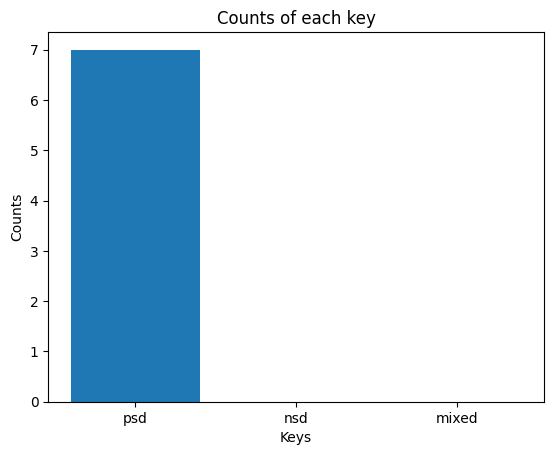

In [ ]:
# Pretty print counts
counter.format_print()

# Plot counts
counter.plot_counts()